<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 8.4: Sentiment Analysis
INSTRUCTIONS:
- Run the cells
- Observe and understand the results
- Answer the questions

Based on the video tutorial **Text Classification with Machine Learning,SpaCy and Scikit(Sentiment Analysis)** by **Jesse E. Agbe (JCharis)**.

## Data Source: UCI
### UCI - Machine Learning Repository
- Center for Machine Learning and Intelligent Systems

The [**UCI Machine Learning Repository**](http://archive.ics.uci.edu/ml/about.html) is a collection of databases, domain theories, and data generators that are used by the machine learning community for the empirical analysis of machine learning algorithms.

### Dataset
- [Sentiment Labelled Sentences Data Set](http://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences)

### Abstract
The dataset contains sentences labelled with positive or negative sentiment.

- Data Set Characteristics: Text
- Number of Instances: 3000
- Area: N/A
- Attribute Characteristics: N/A
- Number of Attributes: N/A
- Date Donated: 2015-05-30
- Associated Tasks: Classification
- Missing Values? N/A
- Number of Web Hits: 102584

### Source
Dimitrios Kotzias dkotzias '@' ics.uci.edu

### Data Set Information
This dataset was created for the Paper 'From Group to Individual Labels using Deep Features', Kotzias et. al,. KDD 2015

Please cite the paper if you want to use it :)

It contains sentences labelled with positive or negative sentiment.

### Format
sentence &lt;tab&gt; score &lt;newline&gt;

### Details
Score is either 1 (for positive) or 0 (for negative)

The sentences come from three different websites/fields:
- imdb.com
- amazon.com
- yelp.com

For each website, there exist **500 positive** and **500 negative** sentences. Those were selected randomly for larger datasets of reviews.

We attempted to select sentences that have a clearly positive or negative connotaton, the goal was for no neutral sentences to be selected.

For the full datasets look:

- **imdb**: Maas et. al., 2011 _Learning word vectors for sentiment analysis_
- **amazon**: McAuley et. al., 2013 _Hidden factors and hidden topics: Understanding rating dimensions with review text_
- **yelp**: [Yelp dataset challenge](http://www.yelp.com/dataset_challenge)


### Attribute Information
The attributes are text sentences, extracted from reviews of products, movies, and restaurants

### Relevant Papers
**From Group to Individual Labels using Deep Features**, Kotzias et. al,. KDD 2015

### Citation Request
**From Group to Individual Labels using Deep Features**, Kotzias et. al,. KDD 2015

## Import libraries

In [1]:
## Import Libraries
import pandas as pd

import regex as re
import spacy

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import warnings
warnings.filterwarnings('ignore')

## Load data

Load Yelp, Amazon and Imdb Data.

Hint: Source is separated by <tab>s and has no headers.

In [9]:
column_names = ['comment', 'sentiment']

# ANSWER
yelp = pd.read_csv('../../data/yelp_labelled.txt', delimiter='\t', names=column_names)
imdb = pd.read_csv('../../data/imdb_labelled_fixed.txt', delimiter='\t', names=column_names)
amazon = pd.read_csv('../../data/amazon_cells_labelled.txt', delimiter='\t', names=column_names)


## Inspect the data

Check your datasets.

In [21]:
# ANSWER
print(yelp.head(30))

yelp.shape

                                              comment  sentiment
0                            Wow... Loved this place.          1
1                                  Crust is not good.          0
2           Not tasty and the texture was just nasty.          0
3   Stopped by during the late May bank holiday of...          1
4   The selection on the menu was great and so wer...          1
5      Now I am getting angry and I want my damn pho.          0
6               Honeslty it didn't taste THAT fresh.)          0
7   The potatoes were like rubber and you could te...          0
8                           The fries were great too.          1
9                                      A great touch.          1
10                           Service was very prompt.          1
11                                 Would not go back.          0
12  The cashier had no care what so ever on what I...          0
13  I tried the Cape Cod ravoli, chicken,with cran...          1
14  I was disgusted becau

(1000, 2)

In [16]:
print(imdb.head())

imdb.shape

                                             comment  sentiment
0  A very, very, very slow-moving, aimless movie ...          0
1  Not sure who was more lost - the flat characte...          0
2  Attempting artiness with black & white and cle...          0
3       Very little music or anything to speak of.            0
4  The best scene in the movie was when Gerardo i...          1


(1000, 2)

In [17]:
print(amazon.head())

amazon.shape

                                             comment  sentiment
0  So there is no way for me to plug it in here i...          0
1                        Good case, Excellent value.          1
2                             Great for the jawbone.          1
3  Tied to charger for conversations lasting more...          0
4                                  The mic is great.          1


(1000, 2)

## Merge the data

Merge all three datasets.

In [19]:
# ANSWER
merged_df = pd.concat([yelp, imdb, amazon], ignore_index=True)

merged_df.shape


(3000, 2)

In [22]:
merged_df.head(30)

,comment,sentiment
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
5,Now I am getting angry and I want my damn pho.,0
6,Honeslty it didn't taste THAT fresh.),0
7,The potatoes were like rubber and you could te...,0
8,The fries were great too.,1
9,A great touch.,1


## Export the data

Export merged datasets to as csv file.

In [20]:
# ANSWER
merged_df.to_csv('../../data/merged_text.csv', index=False)


## Prepare the stage
- Load spaCy

In [26]:
nlp = spacy.load("en_core_web_sm")

## Prepare the text
All the text handling and preparation concerned with the changes and modifications from the raw source text to a format that will be used for the actual processing, things like:
- handle encoding
- handle extraneous and international characters
- handle symbols
- handle metadata and embedded information
- handle repetitions (such multiple spaces or newlines)

Clean text.

In [27]:
def clean_text(text):
    # reduce multiple spaces and newlines to only one
    text = re.sub(r'(\s\s+|\n\n+)', r'\1', text)
    # remove double quotes
    text = re.sub(r'"', '', text)

    return text

In [30]:
# ANSWER
merged_df['comment'] = merged_df['comment'].apply(clean_text)

merged_df.sample(10)

,comment,sentiment
2246,Excellent wallet type phone case.,1
1006,Wasted two hours.,0
592,OMG I felt like I had never eaten Thai food un...,1
614,An absolute must visit!,1
2379,Soyo technology sucks.,0
2701,You can't beat the price on these.,1
2682,This product is clearly not ready for prime ti...,0
2224,There's a horrible tick sound in the backgroun...,0
1688,I can't see how this movie can be an inspirati...,0
2206,"The 1.2 mega pixel camera, being a part of a p...",1


## Work the text
Concern with the meaning and the substance of the content to extract actual information.

Hint: Use techniques learned in previous labs. Remove StopWords, Punctuation, Lemmatize etc.

In [31]:
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

def convert_text(text):
    '''
    Use techniques learned in previous labs. Remove StopWords, Punctuation, Lemmatize etc.
    '''
    tokens = word_tokenize(text)

    table = str.maketrans('', '', string.punctuation)
    stripped = [word.translate(table) for word in tokens]
    
    # Remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]

    stop_words = set(stopwords.words('english'))
    words = [word for word in words if not word in stop_words]

    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    lemmatized = [lemmatizer.lemmatize(word) for word in words]

    return ' '.join(lemmatized)

In [33]:
%%time
merged_df['short'] = merged_df['comment'].apply(convert_text)

CPU times: total: 4.28 s
Wall time: 4.77 s


In [35]:
merged_df.sample(10)

,comment,sentiment,short
1536,the movie is littered with overt racial slurs ...,0,movie littered overt racial slur towards black...
299,The food was excellent and service was very good.,1,The food excellent service good
159,"Unfortunately, we must have hit the bakery on ...",0,Unfortunately must hit bakery leftover day eve...
102,"Best Buffet in town, for the price you cannot ...",1,Best Buffet town price beat
1318,All the characters in this film are tremendous...,1,All character film tremendously well played
1915,I didn't realize how wonderful the short reall...,1,I nt realize wonderful short really last two s...
2800,"Good , works fine.",1,Good work fine
2369,I was looking for this headset for a long time...,1,I looking headset long time I got I could nt h...
2522,I ended up sliding it on the edge of my pants ...,1,I ended sliding edge pant back pocket instead
19,did not like at all.,0,like


## Modelling

In [36]:
# helper function to show results and charts
def show_summary_report(actual, prediction, probabilities):

    if isinstance(actual, pd.Series):
        actual = actual.values.astype(int)
    prediction = prediction.astype(int)

    accuracy_ = accuracy_score(actual, prediction)
    precision_ = precision_score(actual, prediction)
    recall_ = recall_score(actual, prediction)
    roc_auc_ = roc_auc_score(actual, probabilities)

    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('ROC AUC  : %.4f                                                                     Best: 1, Worst: < 0.5' % roc_auc_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

    # Confusion Matrix
    mat = confusion_matrix(actual, prediction)

    # Precision/Recall
    precision, recall, _ = precision_recall_curve(actual, probabilities)
    average_precision = average_precision_score(actual, probabilities)
    
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(actual, probabilities)
    roc_auc = auc(fpr, tpr)


    # plot
    fig, ax = plt.subplots(1, 3, figsize = (18, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

    # Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Blues', ax = ax[0])

    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('True label')
    ax[0].set_ylabel('Predicted label')
    
    # Precision/Recall
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color = 'b', alpha = 0.2, where = 'post')
    ax[1].fill_between(recall, precision, alpha = 0.2, color = 'b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')

    # ROC
    ax[2].plot(fpr, tpr, color = 'darkorange', lw = 2, label = 'ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color = 'navy', lw = 2, linestyle = '--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate')
    ax[2].set_ylabel('True Positive Rate')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc = 'lower right')

    plt.show()
    
    return (accuracy_, precision_, recall_, roc_auc_)

In [37]:
# Features and Labels
X = merged_df['short']
y = merged_df['sentiment']

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## Use Bag-of-Words

In [38]:
# create a matrix of word counts from the text
counts = CountVectorizer()

In [39]:
# do the actual counting
A = counts.fit_transform(X_train, y_train)

In [40]:
# create a classifier using SVC
classifier = SVC(kernel='linear', probability=True)

In [42]:
# train the classifier with the training data
classifier.fit(A.toarray(), y_train)

SVC(kernel='linear', probability=True)

In [43]:
# do the transformation for the test data
# NOTE: use `transform()` instead of `fit_transform()`
B = counts.transform(X_test)

In [45]:
# make predictions based on the test data
predictions = classifier.predict(B.toarray())
predictions

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0,

In [46]:
# check the accuracy
print('Accuracy: %.4f' % accuracy_score(y_test, predictions))

Accuracy: 0.7950


## Repeat using TF-IDF
TF-IDF = Term Frequency - Inverse Document Frequency

In [47]:
# create a matrix of word counts from the text
# use TF-IDF
tfidf = TfidfVectorizer()
# do the actual counting
A = tfidf.fit_transform(X_train, y_train)

# train the classifier with the training data
classifier.fit(A.toarray(), y_train)

# do the transformation for the test data
# NOTE: use `transform()` instead of `fit_transform()`
B = tfidf.transform(X_test)

# make predictions based on the test data
predictions = classifier.predict(B.toarray())

# check the accuracy
print('Accuracy: %.4f' % accuracy_score(y_test, predictions))

Accuracy: 0.8000


## Repeating it all for comparision
Repeating the whole lot in one big block

Find 'Accuracy', 'Precision', 'Recall', 'ROC_AUC' using CountVectorizer and TfidfVectorizer and keep the result in a dataframe.

In [48]:
# ANSWER
def evaluate_vectorizer(vectorizer, X_train, y_train, X_test, y_test):
    # Fit and transform the training data
    A = vectorizer.fit_transform(X_train)

    # Create and train the classifier
    classifier = SVC(kernel='linear', probability=True)
    classifier.fit(A.toarray(), y_train)

    # Transform the test data
    B = vectorizer.transform(X_test)

    # Make predictions
    predictions = classifier.predict(B.toarray())
    probabilities = classifier.predict_proba(B.toarray())[:, 1]  # Probabilities for ROC_AUC

    # Use your show_summary_report function
    return show_summary_report(y_test, predictions, probabilities)


Accuracy : 0.7950 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.7987 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7961 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8649                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


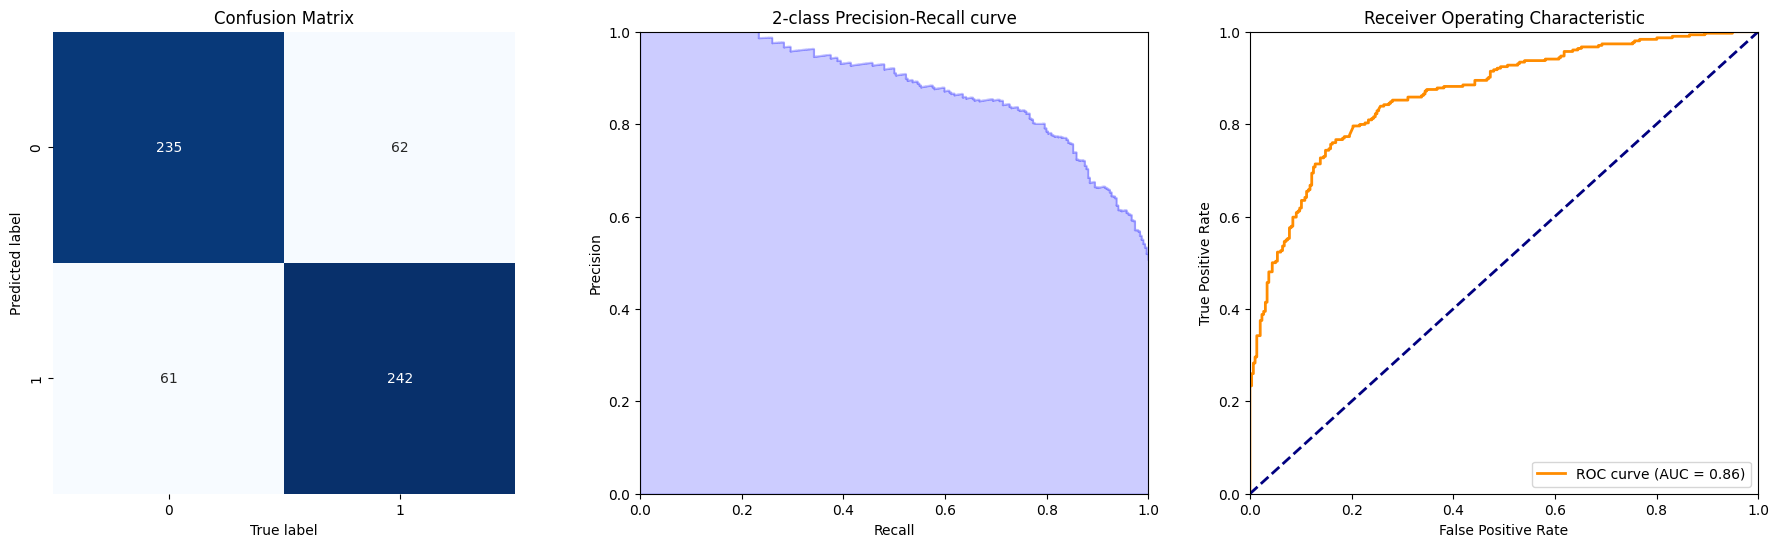

Accuracy : 0.8000 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.8108 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7895 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
ROC AUC  : 0.8740                                                                     Best: 1, Worst: < 0.5
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


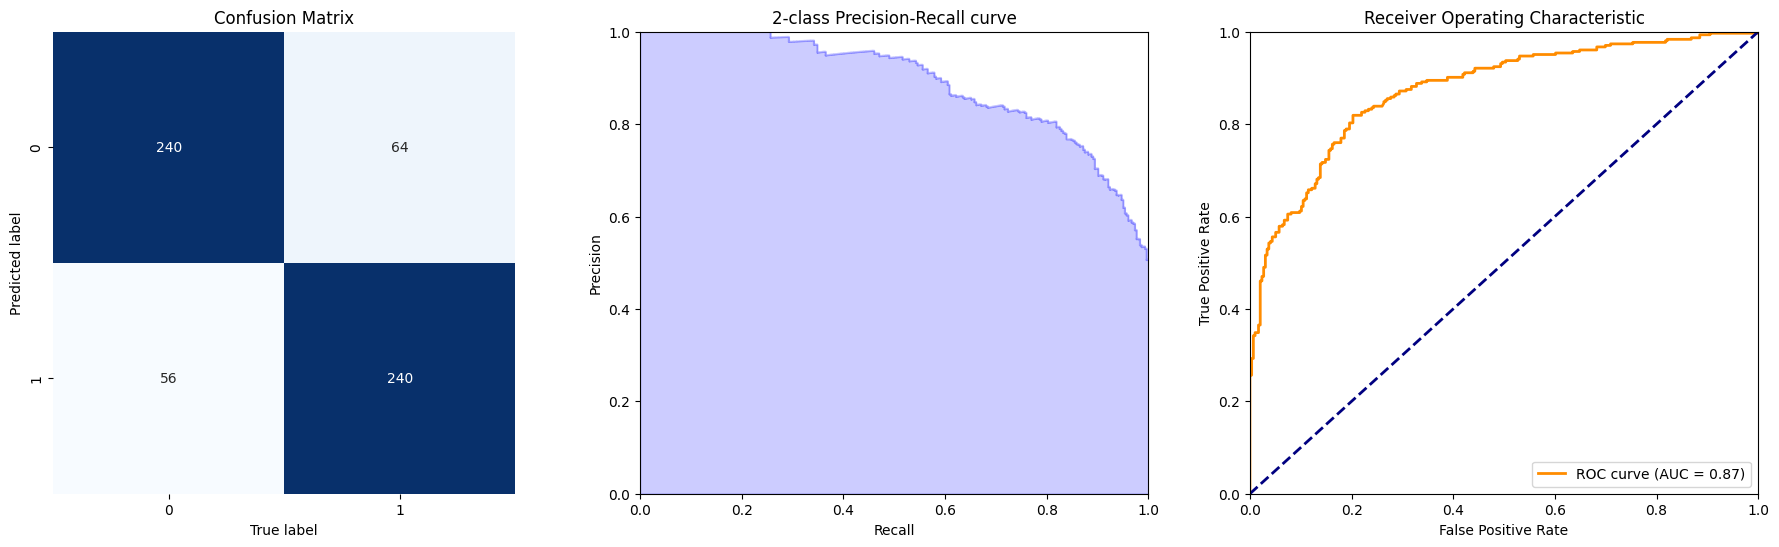

                 Accuracy  Precision    Recall   ROC_AUC
CountVectorizer     0.795   0.798680  0.796053  0.864854
TfidfVectorizer     0.800   0.810811  0.789474  0.873989


In [49]:
# Evaluate using CountVectorizer
count_metrics = evaluate_vectorizer(CountVectorizer(), X_train, y_train, X_test, y_test)

# Evaluate using TfidfVectorizer
tfidf_metrics = evaluate_vectorizer(TfidfVectorizer(), X_train, y_train, X_test, y_test)

# Create a DataFrame to hold the results
results_df = pd.DataFrame([count_metrics, tfidf_metrics],
                          columns=['Accuracy', 'Precision', 'Recall', 'ROC_AUC'],
                          index=['CountVectorizer', 'TfidfVectorizer'])

print(results_df)



---



---



> > > > > > > > > © 2023 Institute of Data


---



---



